In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import datetime
from group_lasso import GroupLasso
from sklearn.utils import resample, check_random_state
from sklearn.model_selection import cross_val_score, cross_validate

In [2]:
def standardize(X,y):
    # Standardize X to have mean = 0 std = 1
    # Standardize y to have mean = 0
    X_scaled = (X-np.mean(X,axis=0))/np.std(X,axis=0)
    y_scaled = y-np.mean(y)
    return X_scaled, y_scaled


def plot_coefficients(beta,alpha,alpha_opt=10,name=None):
    # Plotting regression coefficients vs lambda
    beta_opt = beta[:,np.argmin(np.abs(alpha-alpha_opt))]
    plt.figure()
    plt.plot(np.log10(alpha),beta.T,'-')
    plt.plot(np.log10(alpha_opt)*np.array([1,1]), [np.min(beta), np.max(beta)], 'k--')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\beta$')
    plt.title(name)
    plt.show()

    
def plot_CV_MSE(alpha_vals, mse, alpha_opt, name=None):
    mse_mean = np.mean(mse,axis=1)
    mse_std = np.std(mse,axis=1)
    plt.figure()
    plt.errorbar(np.log10(alpha_vals), mse_mean, mse_std)
    plt.plot(np.log10([alpha_opt,alpha_opt]), [0,np.max(mse)],'k--')
    plt.xlabel(r'log($\lambda$)')
    plt.ylabel('MSE')
    plt.title(name)
    plt.show()
    print('Optimal value of lambda is: ', np.round(alpha_opt,3))

    
def Feature_selection_cv(X,y, alpha_vals, reg):
    n_alpha = len(alpha_vals)
    beta = np.zeros((X.shape[1],n_alpha))
    cv_outs = []
    min_cv = np.inf
    for i in range(n_alpha):
        if type(reg) == GroupLasso:   # Handling group lasso
            reg.group_reg=group_reg*alpha_vals[i]#alpha_vals[i],
            reg.l1_reg=(1-group_reg)*alpha_vals[i]
            reg.fit(X,y)
            beta[:,i] = reg.coef_.reshape(-1)
        else:
            reg.alpha = alpha_vals[i]
            reg.fit(X,y)
            beta[:,i] = reg.coef_
        cv_out = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
        cv_outs.append(cv_out)
        if -cv_out.mean() < min_cv:
            min_cv = -cv_out.mean()
            min_alpha = alpha_vals[i]
        
    beta_best = beta[:,alpha_vals==min_alpha]    
    return beta_best
            
    
def Bootstrap_loop(X,y,alpha_vals,reg,b=20,N_samples=100):
    
    betas = np.zeros((N_samples,X.shape[1]))
    for n in range(N_samples):
            index_vector = np.arange(len(y))
            boot_index = np.random.choice(index_vector, size=b)
            X_sample = X[boot_index,:]
            y_sample = y[boot_index]
            beta_best = Feature_selection_cv(X_sample,y_sample, alpha_vals, reg)
            betas[n,:] = beta_best.reshape(-1)
    return betas

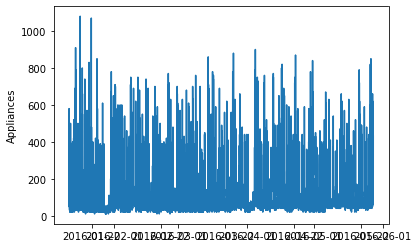

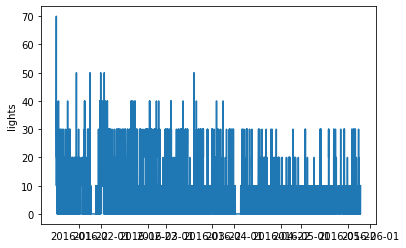

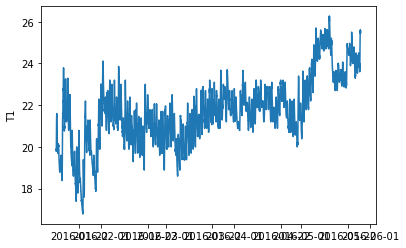

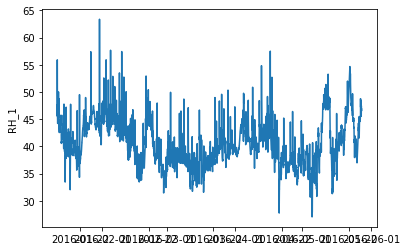

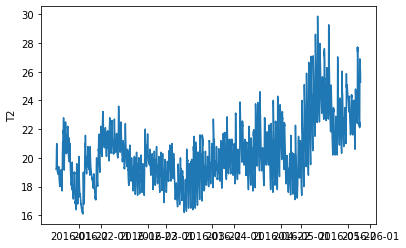

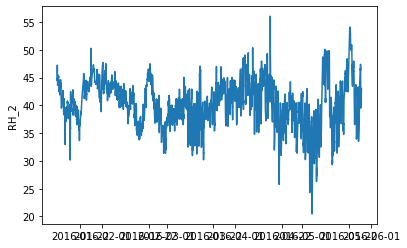

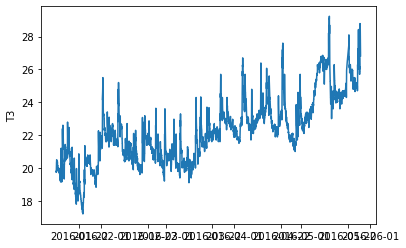

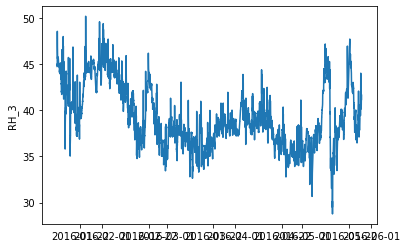

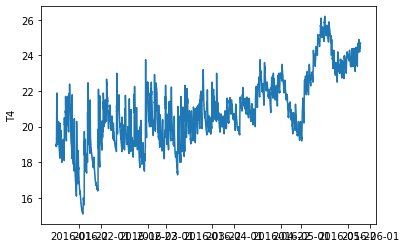

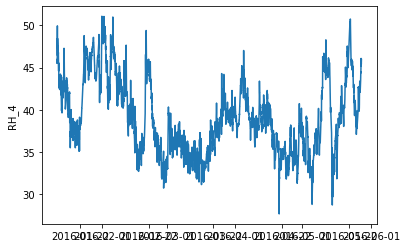

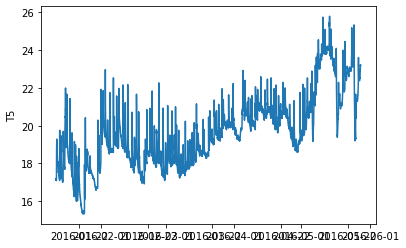

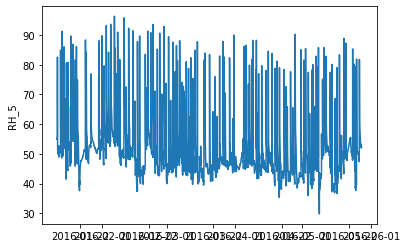

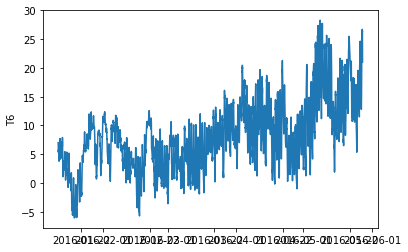

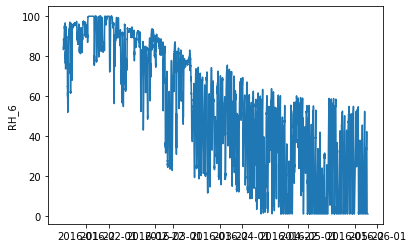

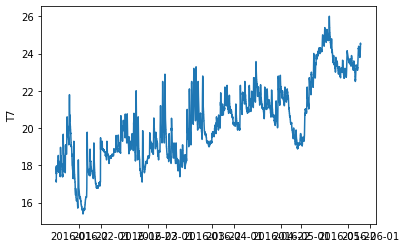

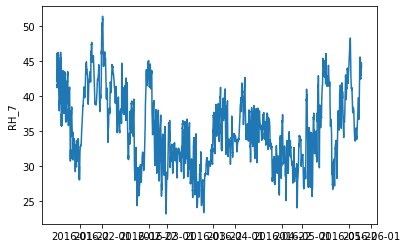

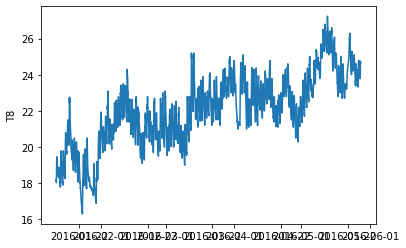

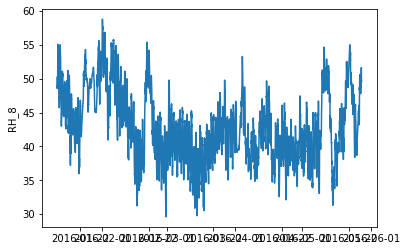

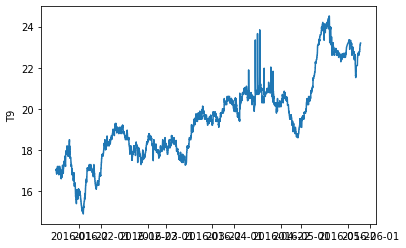

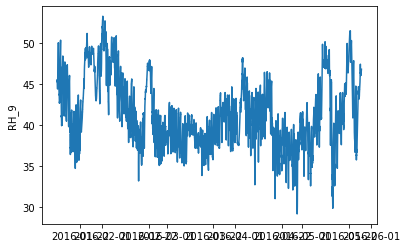

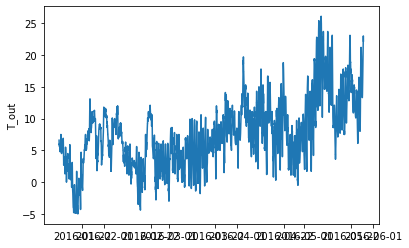

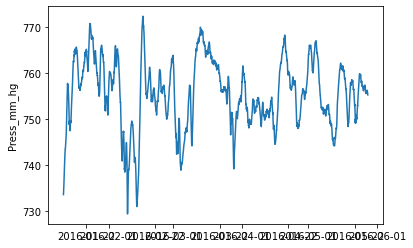

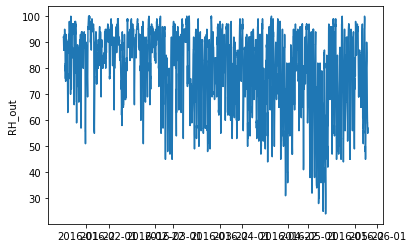

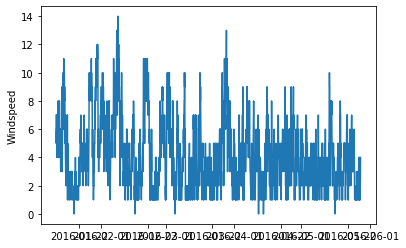

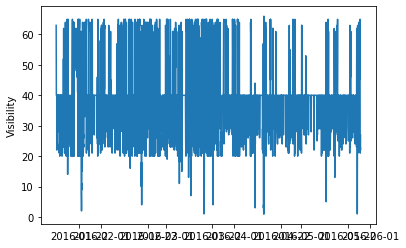

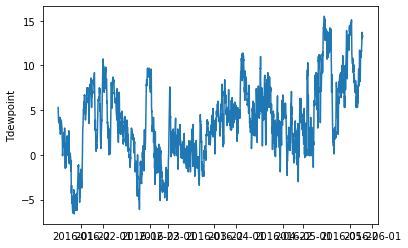

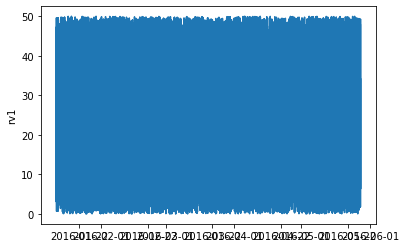

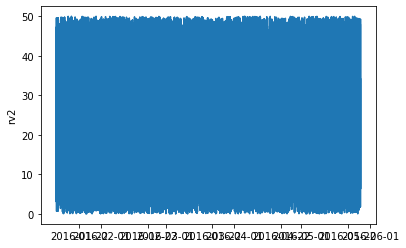

In [3]:
df = pd.read_csv('energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

for i in range(len(df.columns)):
    plt.figure()
    plt.plot(df[df.columns[i]])
    plt.ylabel(df.columns[i])
    plt.show()

### Taking an n-hour mean

In [4]:
df = df.resample('24h').mean()

### Generating extra features to describe time
weekday: number [0,6]\
weekstatus: binary describing weekend (1) or not (0)\
NSM: Number of Seconds from Midnight

These are used for filtering the data

In [5]:
weekday = np.zeros(len(df))
weekstatus = np.zeros(len(df))
NSM = np.zeros(len(df))
month = np.zeros(len(df))

for i in range(len(df)):
    weekday[i] = df.index[i].weekday()
    weekstatus[i] = True if weekday[i] >= 5 else False  # False for workday, True for weekend
    NSM[i] = (df.index[i] - df.index[i].replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    month[i] = df.index[i].month

df['weekday'] = weekday
df['week status'] = weekstatus
df['NSM'] = NSM
df['month'] = month

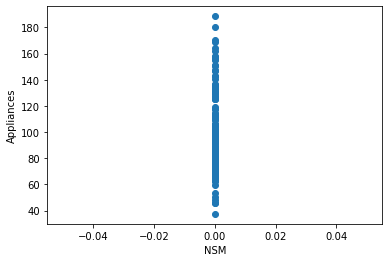

In [6]:
plt.figure()
plt.scatter(df['NSM'],df['Appliances'])
plt.xlabel('NSM')
plt.ylabel('Appliances')
plt.show()

### Filtering data and making training set
Example: Only february, after 16:00 and workday

In [7]:
#df_train = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]
df_train = df[(df.index.month==2)]
df_train = df_train.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

# Training data
y = np.array(df_train['Appliances']).reshape(-1,1)
X = np.array(df_train[df_train.columns[1:]])
X, y = standardize(X,y)

### Cross validation parameters

In [8]:
# Creating array of penalties

n_alpha = 100 # Number of penalties
min_alpha = .01 # min penalty
max_alpha = 200 # Maximum penalty
alpha_vals = np.logspace(np.log10(min_alpha),np.log10(max_alpha),n_alpha)
alpha_vals = alpha_vals[::-1] # reversing array (some sklearn standard?)

### Ordinary least squares

In [9]:
reg_lstsq = linear_model.LinearRegression(fit_intercept=False)
beta_ls = reg_lstsq.fit(X,y).coef_

### Lasso

In [10]:
beta_lasso = np.zeros((X.shape[1],n_alpha))

cv_outs_lasso = []
min_cv = np.inf
for i in range(n_alpha):
    reg = linear_model.Lasso(alpha=alpha_vals[i], max_iter = 10000, fit_intercept = False)
    reg.fit(X,y)
    beta_lasso[:,i] = reg.coef_
    cv_out = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_outs_lasso.append(cv_out)
    if -cv_out.mean() < min_cv:
        min_cv = -cv_out.mean()
        lasso_min_alpha = alpha_vals[i]
    
# Best model   
reg_lasso = linear_model.Lasso(alpha=lasso_min_alpha, max_iter = 10000, fit_intercept = False)

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.0546523843513, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.617766558491439, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2524138916867855, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.62929386033403, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.657981277286126, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.95430091516303, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

### Ridge

In [11]:
beta_ridge = np.zeros((X.shape[1],n_alpha))
cv_outs_ridge = []
min_cv = np.inf
for i in range(n_alpha):
    reg = linear_model.ElasticNet(alpha=alpha_vals[i], max_iter = 10000, l1_ratio=0, fit_intercept = False)
    reg.fit(X,y)
    beta_ridge[:,i] = reg.coef_
    cv_out = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_outs_ridge.append(cv_out)
    if -cv_out.mean() < min_cv:
        min_cv = -cv_out.mean()
        ridge_min_alpha = alpha_vals[i]
        
# Best model
reg_ridge = linear_model.ElasticNet(alpha=ridge_min_alpha, max_iter = 10000, l1_ratio=0.0, fit_intercept = False)

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9635.475253977998, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7361.499668108357, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8721.20035730016, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9157.94715783259, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6916.5549245246075, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9625.647288047598, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9250.530620315096, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9145.957096439986, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6902.810111394048, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6884.887197498635, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9595.768036385918, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7337.197192872103, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9418.084848900498, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8848.979786469134, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9289.94121032658, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9248.879210000865, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9189.613136981343, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9083.402478919948, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6794.822684244651, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9509.438006325712, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7279.45678894171, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7246.642430470989, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8476.249392910564, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7934.266126972813, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9212.32654462073, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9229.368876682816, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8710.84372987786, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8916.468083400901, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8973.663883213196, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8861.772165636545, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8774.135670613428, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6505.749725427742, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9214.114805381485, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9098.211383278911, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6948.7468791924475, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8111.010847280787, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6271.961358209676, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8956.70209663573, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6825.168248802351, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8785.4832141688, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6673.244270913068, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7863.7112847860035, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7346.7046260679235, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8318.320820548994, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8378.319988021967, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7648.082784537766, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7584.7532444495055, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8012.335977150173, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7249.498863544471, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7749.948697517949, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7642.39519834204, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7538.480996121518, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7040.079479608371, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6889.526848948303, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7058.603341909929, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7195.765989080472, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6692.058692322395, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6252.060451213692, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6666.821058278174, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6832.605503598849, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6222.899054326594, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5970.672723664772, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6259.916312661639, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5677.76441558031, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5847.991481069631, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6081.4721464885615, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5710.007410639073, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5222.131395972899, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5088.231683551458, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5393.717146174214, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5311.237653866999, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3464.9885022981966, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4980.810820294405, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3216.151670074496, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5079.210121083947, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4662.088239663602, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2981.5471319804674, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4745.733748483597, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4402.2064799180025, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4354.176786168175, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2758.5516831443406, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3621.0715785418615, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3747.134710666242, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4083.436702789269, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3742.9786086070017, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3323.34839062199, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3518.9034841903785, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3296.631219589198, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3451.533069213675, tolerance: 1.8595145953523877
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3475.53387660994, tolerance: 1.838813033517564
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1932.8670657549847, tolerance: 1.3916670101501372
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3270.3095964294394, tolerance: 1.9329633620689652
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1637.3154013677577, tolerance: 1.4756897297180749
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529:

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2674.014692071891, tolerance: 1.7541410820222472
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2796.5525529122765, tolerance: 1.609402363418586
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2598.0176696490626, tolerance: 1.8995078438091777
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2588.6081287377556, tolerance: 1.9023074560111783
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2073.5361209835546, tolerance: 1.7808288680482154
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2576.878252564018, tolerance: 1.88479827657312
  model = cd_fast.enet_coordinate_descent(
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

### Elastic net

In [12]:
beta_elnet = np.zeros((X.shape[1],n_alpha))
cv_outs_elnet = []
min_cv = np.inf
for i in range(n_alpha):
    reg = linear_model.ElasticNet(alpha=alpha_vals[i], max_iter = 10000, l1_ratio=0.5, fit_intercept = False)
    reg.fit(X,y)
    beta_elnet[:,i] = reg.coef_
    cv_out = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_outs_elnet.append(cv_out)
    if -cv_out.mean() < min_cv:
        min_cv = -cv_out.mean()
        elnet_min_alpha = alpha_vals[i]

# Best model
reg_elnet = linear_model.ElasticNet(alpha=elnet_min_alpha, max_iter = 10000, l1_ratio=0.5, fit_intercept = False)

### Group lasso

In [ ]:
beta_glasso = np.zeros((X.shape[1],n_alpha))
#group_keys= {"T":-1,
#            "RH":-1,
#            "":-1}
group_keys= {"T":1,
            "RH":2,
            "":-1}

groups = []
for var_name in df_train.columns[1:]:
    for key, value in group_keys.items():
        if key in var_name:
            groups.append(value)
            break
# Group the rooms, and outside together
groups=[-1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, -1, -1]
print(*zip(groups, df_train.columns[1:]))
cv_outs = []
min_cv = np.inf
group_reg = 0.05
for i in range(n_alpha):
    reg = GroupLasso(
    groups=groups,
    group_reg=group_reg*alpha_vals[i],#alpha_vals[i],
    l1_reg=(1-group_reg)*alpha_vals[i],
    frobenius_lipschitz=True,
    #scale_reg="inverse_group_size",
    #scale_reg="inverse_group_size",
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )
    cv_out = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_outs.append(cv_out)
    reg.fit(X, y)
    beta_glasso[:,i] = reg.coef_.reshape(-1,)
    #print(f"mean {cv_out.mean()}, stdev {cv_out.std()}")
    if -cv_out.mean() < min_cv:
        min_cv = -cv_out.mean()
        gl_min_alpha = alpha_vals[i]
        

(-1, 'lights') (1, 'T1') (1, 'RH_1') (2, 'T2') (2, 'RH_2') (3, 'T3') (3, 'RH_3') (4, 'T4') (4, 'RH_4') (5, 'T5') (5, 'RH_5') (6, 'T6') (6, 'RH_6') (7, 'T7') (7, 'RH_7') (8, 'T8') (8, 'RH_8') (9, 'T9') (9, 'RH_9') (10, 'T_out') (10, 'Press_mm_hg') (10, 'RH_out') (10, 'Windspeed') (10, 'Visibility') (10, 'Tdewpoint') (-1, 'rv1') (-1, 'rv2')


C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\martin29\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_p

In [ ]:
# Best model
reg_gl = GroupLasso(
    groups=groups,
    group_reg=group_reg*gl_min_alpha,#alpha_vals[i],
    l1_reg=(1-group_reg)*gl_min_alpha,
    frobenius_lipschitz=True,
    #scale_reg="inverse_group_size",
    #scale_reg="inverse_group_size",
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )

### Plotting coefficients vs lambda

In [ ]:
plot_coefficients(beta_ridge, alpha_vals, cv_ridge.alpha_, name='Ridge')
plot_coefficients(beta_lasso, alpha_vals, cv_lasso.alpha_, name='Lasso')
plot_coefficients(beta_elnet, alpha_vals, cv_elnet.alpha_, name='Elastic net')
plot_coefficients(beta_glasso,alpha_vals, gl_min_alpha,name='Grouped lasso')

In [ ]:
plot_CV_MSE(alpha_vals, -np.array(cv_outs_ridge), ridge_min_alpha, 'Ridge')
plot_CV_MSE(alpha_vals, -np.array(cv_outs_lasso), lasso_min_alpha, 'Lasso')
plot_CV_MSE(alpha_vals, -np.array(cv_outs_elnet), elnet_min_alpha, 'Elastic net')
plot_CV_MSE(alpha_vals, -np.array(cv_outs), gl_min_alpha, 'Grouped Lasso')

In [ ]:
data = {'Feature': list(df_train.columns[1:])}
df_results = pd.DataFrame(data)
df_results['Least squares'] = beta_ls.T
df_results['Lasso'] = beta_lasso[:,alpha_vals==lasso_min_alpha]
df_results['Ridge'] = beta_ridge[:,alpha_vals==ridge_min_alpha]
df_results['Elastic net'] = beta_elnet[:,alpha_vals==ridge_min_alpha]
df_results['Group Lasso'] = beta_glasso[:,alpha_vals==gl_min_alpha]
df_results

### Testing with another month

In [ ]:
'''

#df_test = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]

months = [3,4]
regs = [reg_lstsq,reg_lasso,reg_ridge,reg_elnet,reg_glasso]
j = 0

fig, axs = plt.subplots(len(regs),len(months))
fig.set_figheight(15)
fig.set_figwidth(15)

for month in months:

    df_test = df[(df.index.month==month)]
    df_test = df_test.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

    # Testing data
    y_t = np.array(df_test['Appliances']).reshape(-1,1)
    X_t = np.array(df_test[df_test.columns[1:]])
    X_t, y_t = standardize(X_t,y_t)
    y_p = reg_glasso.predict(X_t)

    i = 0
    for reg in regs:
        axs[i,j].plot([min(y_p),max(y_p)],[min(y_p),max(y_p)],'k--')
        axs[i,j].scatter(reg.predict(X_t),y_t)
        axs[i,j].grid()
        axs[i,j].axis('equal')
        print('Train score: ',reg.score(X,y))
        print('Test score: ',reg.score(X_t,y_t))
        i+=1
    j+=1
    
for ax in axs.flat:
    ax.set(xlabel='Predicted appliances', ylabel='True appliances')
for ax in axs.flat:
    ax.label_outer()
plt.show()
'''

### Bootstrap CV

In [ ]:
boot_samples = len(df_train)
boot_size = len(df_train)

reg_lasso = linear_model.Lasso(max_iter = 10000, fit_intercept = False)
betas_lasso = Bootstrap_loop(X,y,alpha_vals,reg_lasso,b=boot_size,N_samples=boot_samples)

reg_ridge = linear_model.ElasticNet(alpha=ridge_min_alpha, max_iter = 10000, l1_ratio=0.0, fit_intercept = False)
betas_ridge = Bootstrap_loop(X,y,alpha_vals,reg_ridge,b=boot_size,N_samples=boot_samples)

reg_elnet = linear_model.ElasticNet(alpha=ridge_min_alpha, max_iter = 10000, l1_ratio=0.0, fit_intercept = False)
betas_elnet = Bootstrap_loop(X,y,alpha_vals,reg_elnet,b=boot_size,N_samples=boot_samples)

'''
reg_gl = reg_gl = GroupLasso(
    groups=groups,
    group_reg=group_reg*gl_min_alpha,#alpha_vals[i],
    l1_reg=(1-group_reg)*gl_min_alpha,
    frobenius_lipschitz=True,
    #scale_reg="inverse_group_size",
    #scale_reg="inverse_group_size",
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )
betas_gl = Bootstrap_loop(X,y,alpha_vals,reg_gl,b=boot_size,N_samples=boot_samples)
'''

In [ ]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_lasso,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Lasso')
plt.show()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_ridge,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Ridge')
plt.show()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_elnet,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Elastic Net')
plt.show()

'''
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_gl,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Group Lasso')
plt.show()
'''

In [ ]:
number_of_zeros = np.sum(betas_lasso == 0,axis=0)
y_pos = np.arange(len(df_train.columns[1:]))

# Sorting in descenting order
labels = df_train.columns[1:][number_of_zeros.argsort()][::-1]
number_of_zeros[::-1].sort()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.barh(y_pos,number_of_zeros ,align='center', alpha=0.5)
plt.yticks(y_pos, labels)
plt.show()